## Time to get your hands dirty. Galaxy vs quasars
#### Data

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used [SQL](https://en.wikipedia.org/wiki/SQL) and want to learn something new it's computing, it's very powerful)

### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from astropy.visualization.hist import hist as fancyhist
from sklearn.preprocessing import LabelEncoder
from astroML.utils import split_samples, completeness_contamination
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
#Loading the data
df_quasar = pd.read_csv("../../solutions/galaxyquasar.csv")
df_quasar

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [3]:
name = df_quasar['class'].copy()

In [4]:
#Defining the vectors for different colors
u_g = np.array(df_quasar['u'] - df_quasar['g'])
g_r = np.array(df_quasar['g'] - df_quasar['r'])
r_i = np.array(df_quasar['r'] - df_quasar['i'])
i_z = np.array(df_quasar['i'] - df_quasar['z'])

In [5]:
#Changing the labels
le = LabelEncoder()
df_quasar['class'] = le.fit_transform(df_quasar['class'])
labels = le.inverse_transform(df_quasar['class'])
class_names = le.classes_
print(class_names)

['GALAXY' 'QSO']


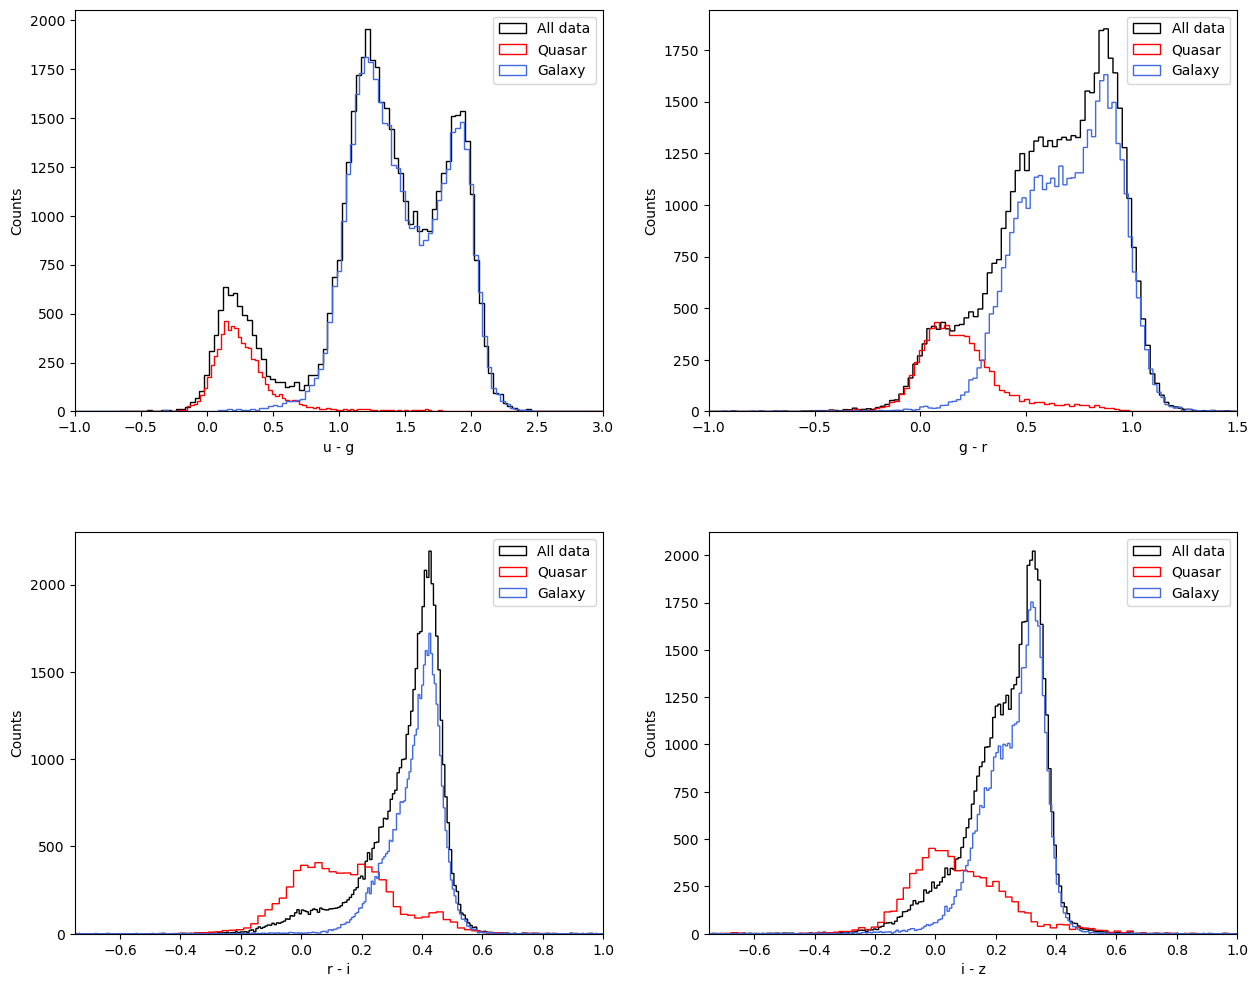

In [6]:
#Histogram of the colors
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

fancyhist(u_g, bins="freedman", ax=axs[0,0], ec='black', histtype='step', label = 'All data')
fancyhist(u_g[df_quasar['class']==1], bins="freedman", ax=axs[0,0], ec='red', histtype='step', label = 'Quasar')
fancyhist(u_g[df_quasar['class']==0], bins="freedman", ax=axs[0,0], ec='royalblue', histtype='step', label = 'Galaxy')
axs[0,0].set_xlabel('u - g')
axs[0,0].set_ylabel('Counts')
axs[0,0].set_xlim(-1, 3)
axs[0,0].legend()

fancyhist(g_r, bins="freedman", ax=axs[0,1], ec='black', histtype='step', label = 'All data')
fancyhist(g_r[df_quasar['class']==1], bins="freedman", ax=axs[0,1], ec='red', histtype='step', label = 'Quasar')
fancyhist(g_r[df_quasar['class']==0], bins="freedman", ax=axs[0,1], ec='royalblue', histtype='step', label = 'Galaxy')
axs[0,1].set_xlabel('g - r')
axs[0,1].set_ylabel('Counts')
axs[0,1].set_xlim(-1, 1.5)
axs[0,1].legend()

fancyhist(r_i, bins="freedman", ax=axs[1,0], ec='black', histtype='step', label = 'All data')
fancyhist(r_i[df_quasar['class']==1], bins="freedman", ax=axs[1,0], ec='red', histtype='step', label = 'Quasar')
fancyhist(r_i[df_quasar['class']==0], bins="freedman", ax=axs[1,0], ec='royalblue', histtype='step', label = 'Galaxy')
axs[1,0].set_xlabel('r - i')
axs[1,0].set_ylabel('Counts')
axs[1,0].set_xlim(-0.75, 1)
axs[1,0].legend()

fancyhist(i_z, bins="freedman", ax=axs[1,1], ec='black', histtype='step', label = 'All data')
fancyhist(i_z[df_quasar['class']==1], bins="freedman", ax=axs[1,1], ec='red', histtype='step', label = 'Quasar')
fancyhist(i_z[df_quasar['class']==0], bins="freedman", ax=axs[1,1], ec='royalblue', histtype='step', label = 'Galaxy')
axs[1,1].set_xlabel('i - z')
axs[1,1].set_ylabel('Counts')
axs[1,1].set_xlim(-0.75, 1)
axs[1,1].legend()

plt.subplots_adjust(hspace=0.3)
plt.show()

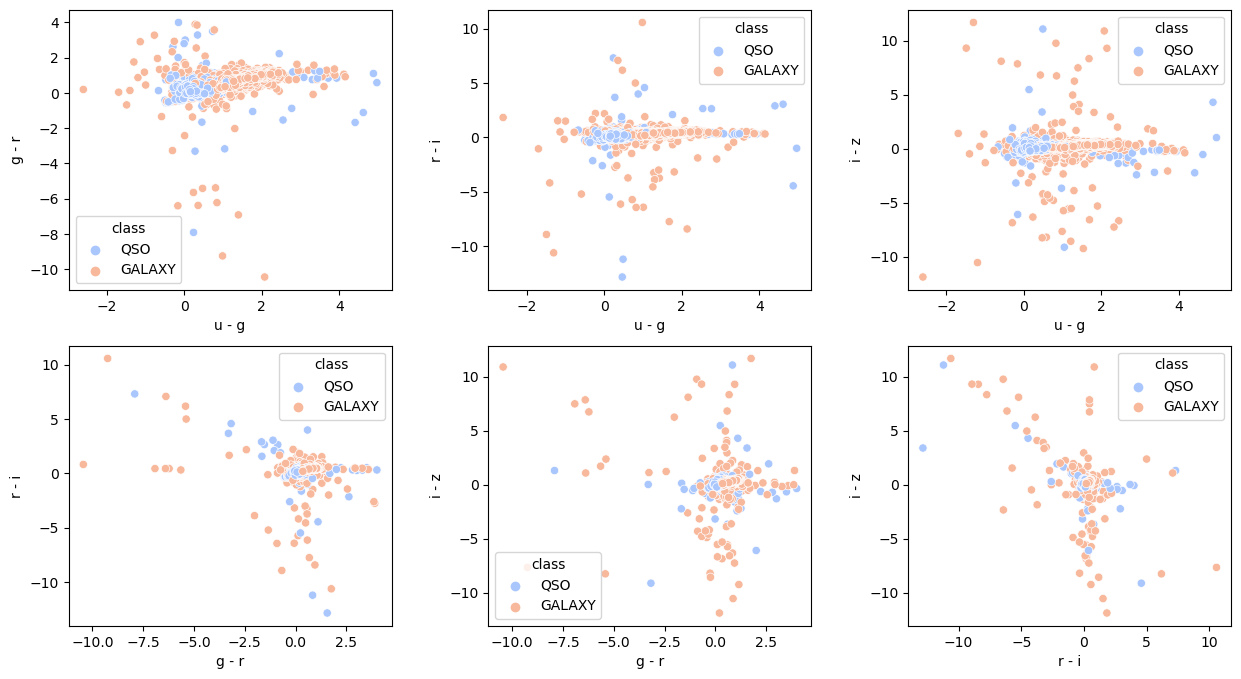

In [7]:
#Scatter plot of all the couples of colors
color = pd.DataFrame({'u - g': u_g, 'g - r': g_r, 'r - i': r_i, 'i - z': i_z})

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

sns.scatterplot(data=color, x='u - g', y='g - r', hue=name, ax = axs[0,0], palette='coolwarm')
sns.scatterplot(data=color, x='u - g', y='r - i', hue=name, ax = axs[0,1], palette='coolwarm')
sns.scatterplot(data=color, x='u - g', y='i - z', hue=name, ax = axs[0,2], palette='coolwarm')
sns.scatterplot(data=color, x='g - r', y='r - i', hue=name, ax = axs[1,0], palette='coolwarm')
sns.scatterplot(data=color, x='g - r', y='i - z', hue=name, ax = axs[1,1], palette='coolwarm')
sns.scatterplot(data=color, x='r - i', y='i - z', hue=name, ax = axs[1,2], palette='coolwarm')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [8]:
#Function that returns the results of the classifier
def models(clf, X_train, X_test, y_train):
    names = []
    probs = []
    
    clf.fit(X_train, y_train)  #Fitting the data
    
    y_probs = clf.predict_proba(X_test)[:, 1]  #Returns probability estimates for the test data
    
    names.append(clf.__class__.__name__)
    probs.append(y_probs)

    return names, y_probs, probs

labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              LogisticRegression='LR',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT')

In [9]:
#Function that comput and plot the ROC curves
def ROC (x, colors = 'All colors'):
    (X_train, X_test), (y_train, y_test) = split_samples(x, df_quasar['class'], [0.70, 0.30], random_state=42)  #Splitting the data in train and test set

    classifiers = [GaussianNB(),
               LinearDiscriminantAnalysis(),
               QuadraticDiscriminantAnalysis(),
               LogisticRegression(),
               KNeighborsClassifier(),
               DecisionTreeClassifier()]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for classifier in classifiers:
        name, y_prob, prob = models(classifier, X_train, X_test, y_train)  
        fpr, tpr, thresh = roc_curve(y_test, y_prob)  #Computing the FPR, TPR (completeness) and the treshold
        precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)  #Computing the precison(efficiency) and the recall (completeness)
        
        #Add (0, 0) as first point
        fpr = np.concatenate([[0], fpr])
        tpr = np.concatenate([[0], tpr])
        # Here we add (1,0) 
        precision = np.concatenate([[0], precision])
        recall = np.concatenate([[1], recall])
        thresh2 = np.concatenate([[0], thresh2])   
        
        axs[0].plot(fpr, tpr, label=labels[name[0]])
        axs[1].plot(precision, recall, label=labels[name[0]])

    #Plotting the results
    #axs[0].set_xlim(0, 0.2)
    axs[0].set_ylim(0, 1.02)
    axs[0].set_xlabel('False positive rate')
    axs[0].set_ylabel('True positive rate')
    axs[0].legend()
    
    axs[1].set_xlabel('Efficiency')
    axs[1].set_ylabel('Completeness')
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0.2, 1.02)

    if colors == 'All colors':
        plt.suptitle(colors, y=0.94)
    elif len(colors)==1:
        plt.suptitle('Color: %s' %(colors[0]), y=0.94)
    elif len(colors)==2:
        plt.suptitle('Colors: %s and %s' %(colors[0], colors[1]), y=0.94)
    elif len(colors)==3:
        plt.suptitle('Colors: %s, %s and %s' %(colors[0], colors[1], colors[2]), y=0.94)
    plt.show()       

#Function to compute the predictions of each classifier
def prediction(X_train, X_test, y_train, y_test):
    pred = []
    accuracy = []   
    classifiers = [GaussianNB(),
               LinearDiscriminantAnalysis(),
               QuadraticDiscriminantAnalysis(),
               LogisticRegression(),
               KNeighborsClassifier(),
               DecisionTreeClassifier()]
    
    for clf in classifiers:
        clf.fit(X_train, y_train)
        prediction = clf.predict(X_test)
        pred.append(prediction)
        accuracy.append(accuracy_score(y_test, prediction))  #Computing the accuracy, it tells us the fraction of data correctly identified.

    return pred, accuracy, classifiers

## Subset of 1 colors

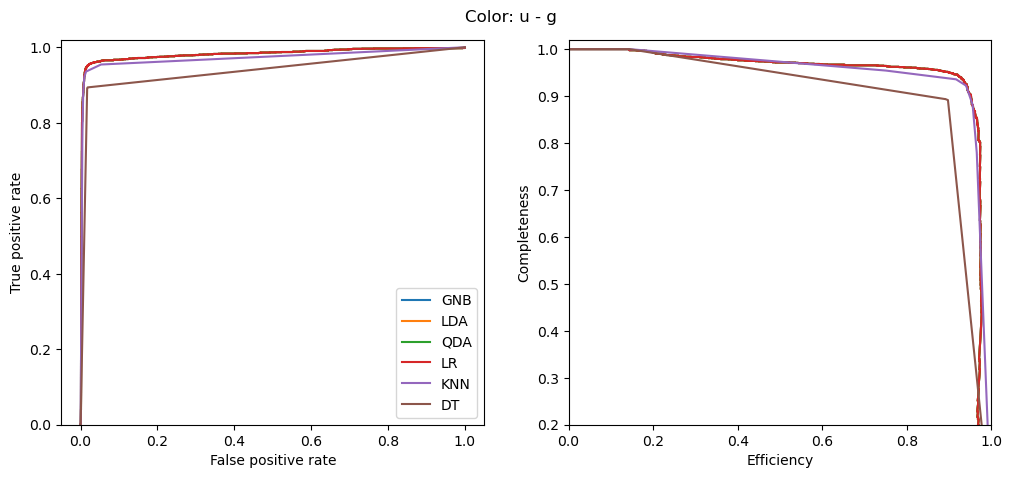

In [10]:
ROC(color.iloc[:, [0]], colors = [color.columns[0]])

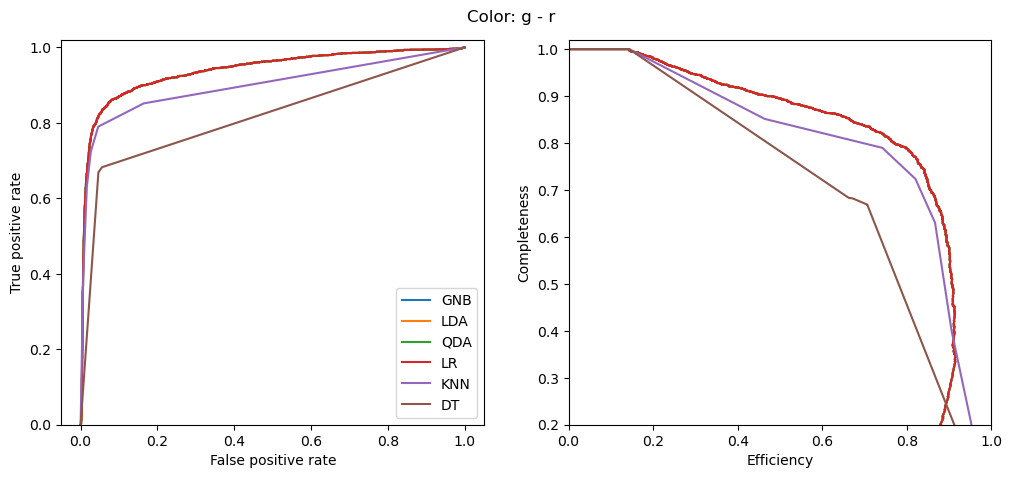

In [11]:
ROC(color.iloc[:, [1]], colors = [color.columns[1]])

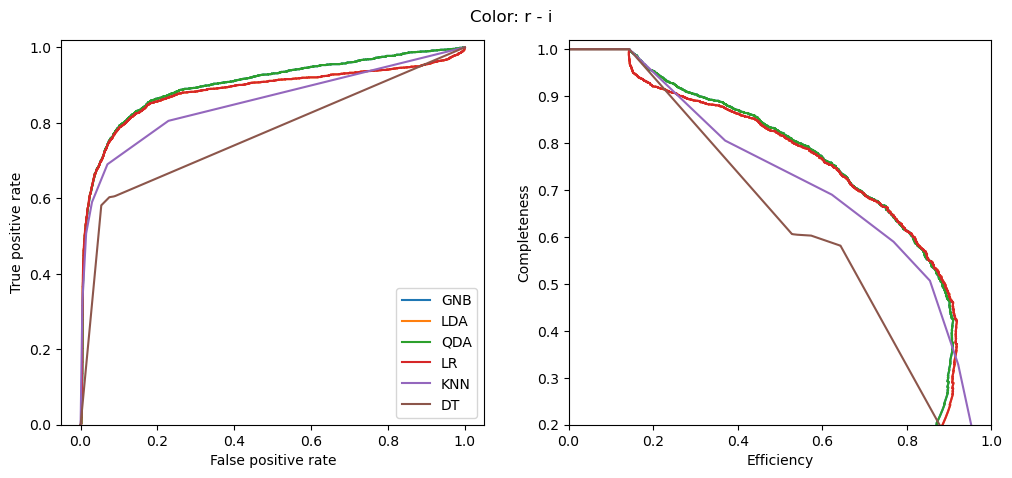

In [12]:
ROC(color.iloc[:, [2]], colors = [color.columns[2]])

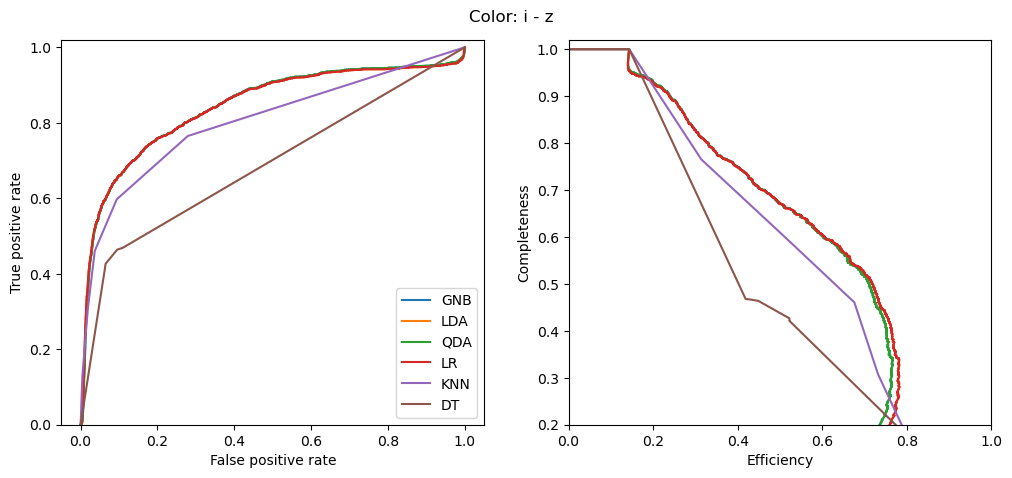

In [13]:
ROC(color.iloc[:, [3]], colors = [color.columns[3]])

We can see that we obtain the best results classifing the color u-g.

## Subset of 2 colors

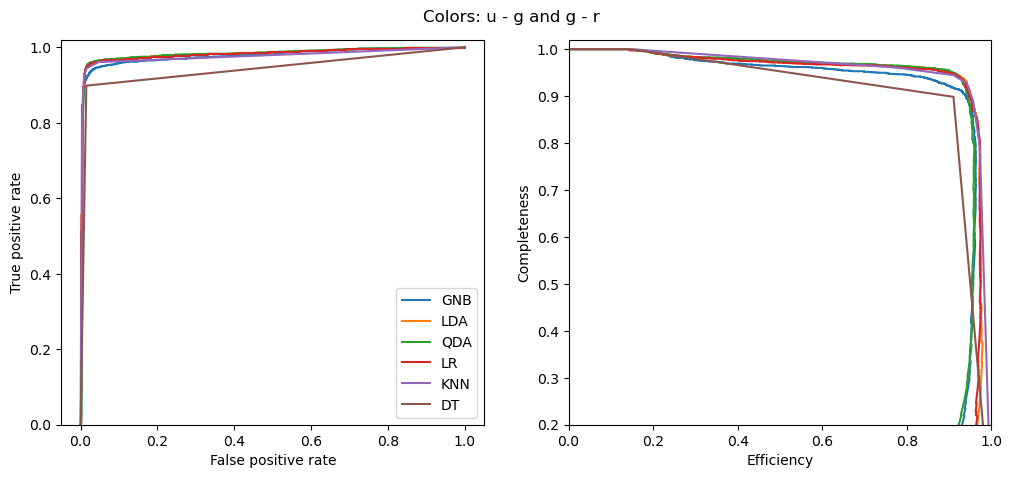

In [14]:
ROC(color.iloc[:, [0, 1]], colors = [color.columns[0], color.columns[1]])

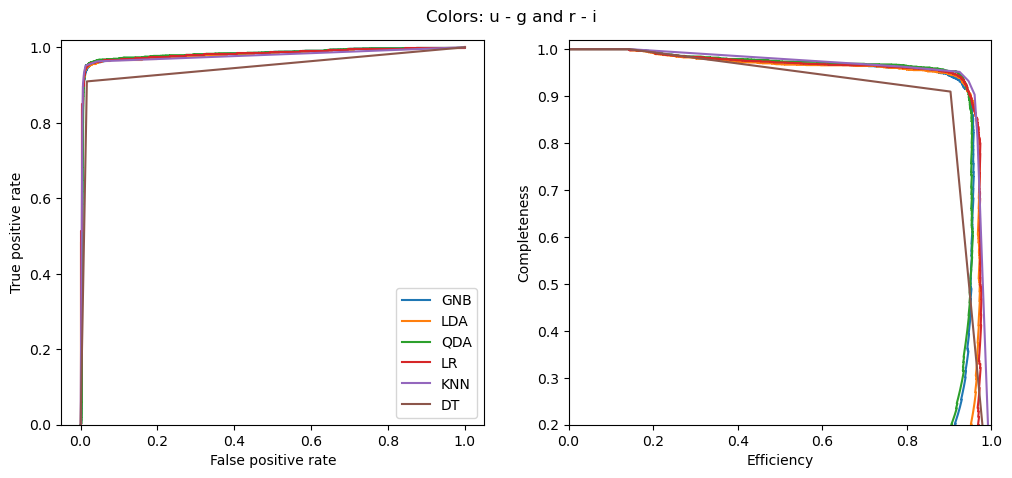

In [15]:
ROC(color.iloc[:, [0, 2]], colors = [color.columns[0], color.columns[2]])

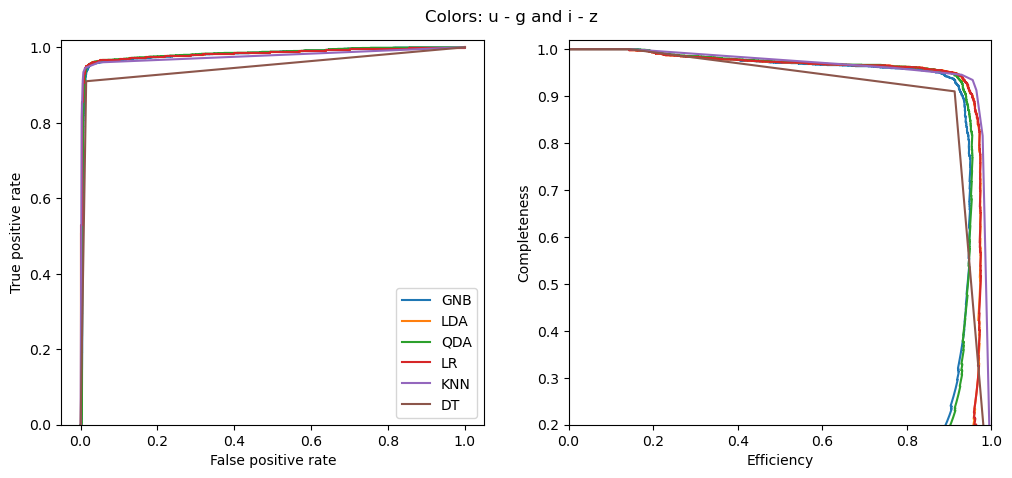

In [16]:
ROC(color.iloc[:, [0, 3]], colors = [color.columns[0], color.columns[3]])

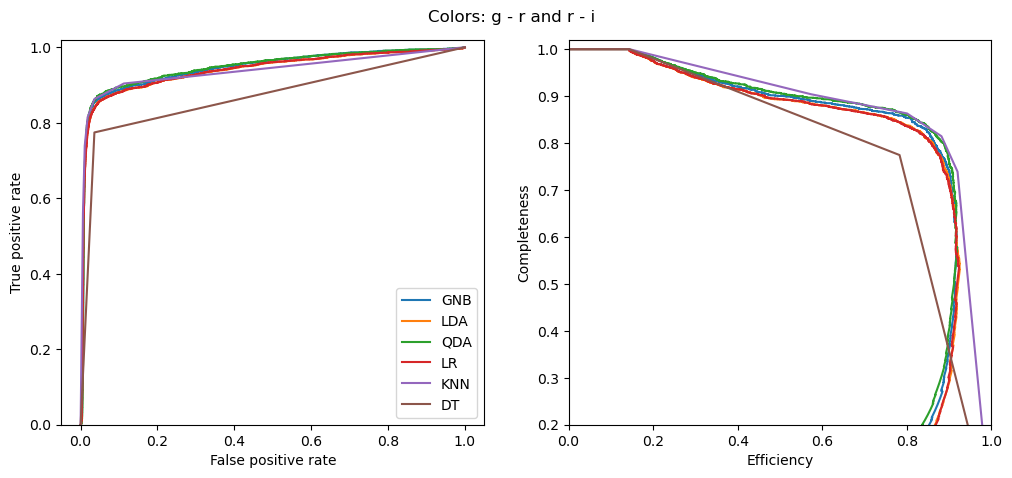

In [17]:
ROC(color.iloc[:, [1, 2]], colors = [color.columns[1], color.columns[2]])

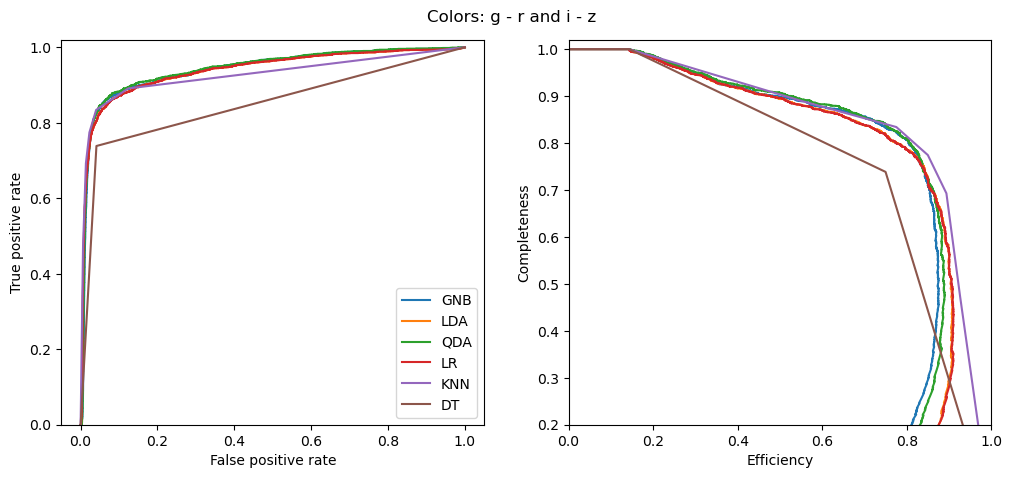

In [18]:
ROC(color.iloc[:, [1, 3]], colors = [color.columns[1], color.columns[3]])

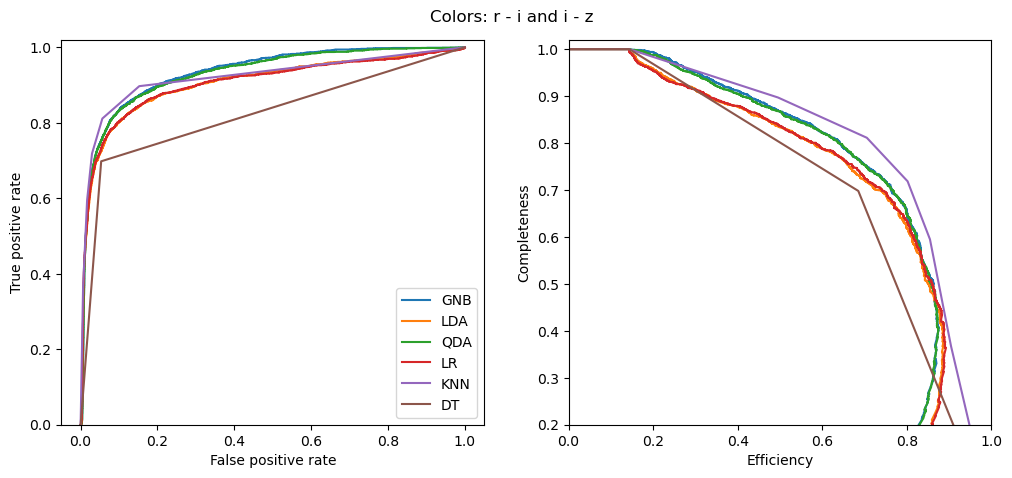

In [19]:
ROC(color.iloc[:, [2, 3]], colors = [color.columns[2], color.columns[3]])

The first three couples give pretty good results.

## Subset of 3 colors

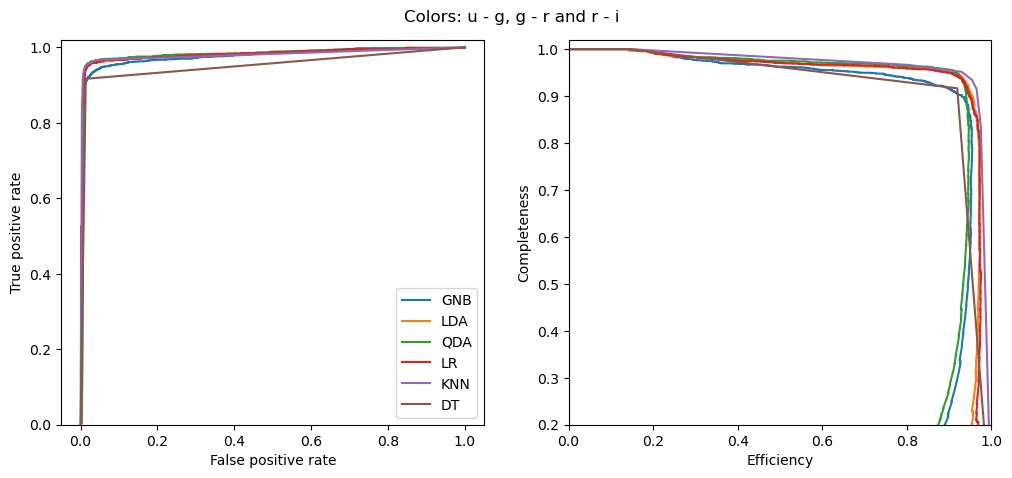

In [20]:
ROC(color.iloc[:, [0, 1, 2]], colors = [color.columns[0], color.columns[1], color.columns[2]])

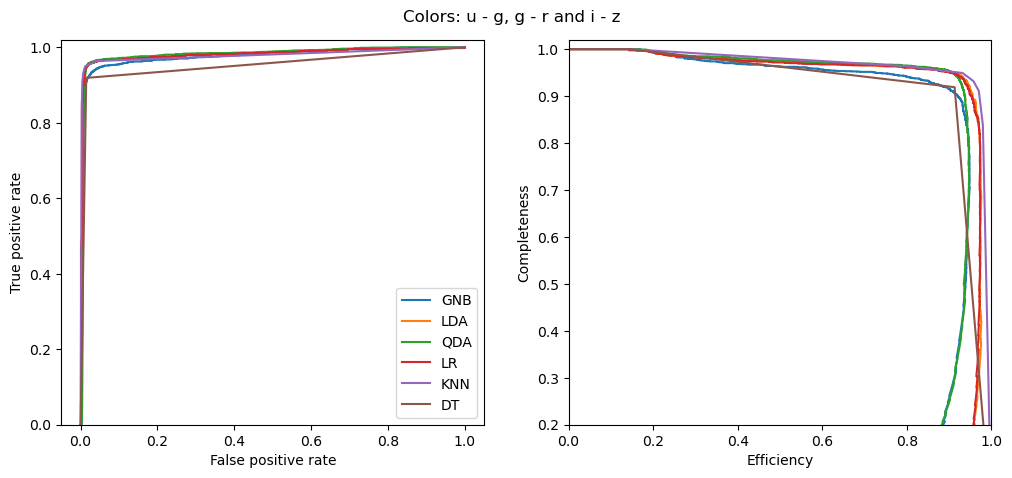

In [21]:
ROC(color.iloc[:, [0, 1, 3]], colors = [color.columns[0], color.columns[1], color.columns[3]])

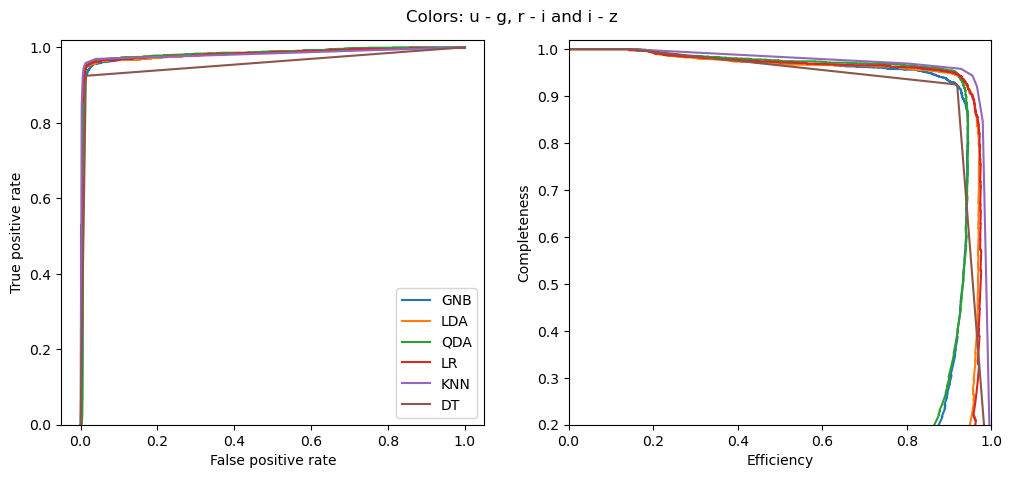

In [22]:
ROC(color.iloc[:, [0, 2, 3]], colors = [color.columns[0], color.columns[2], color.columns[3]])

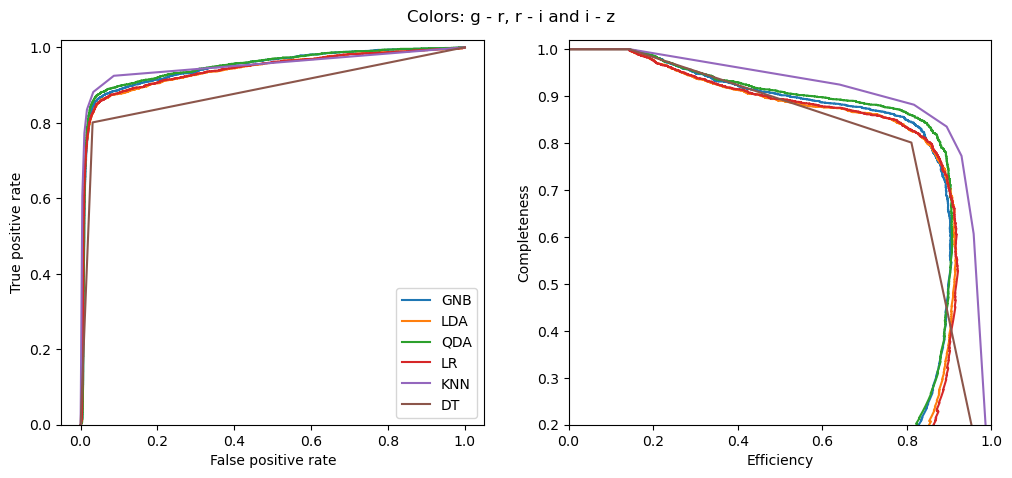

In [23]:
ROC(color.iloc[:, [1, 2, 3]], colors = [color.columns[1], color.columns[2], color.columns[3]])

The first three treplets gives pretty good results.

## All colors

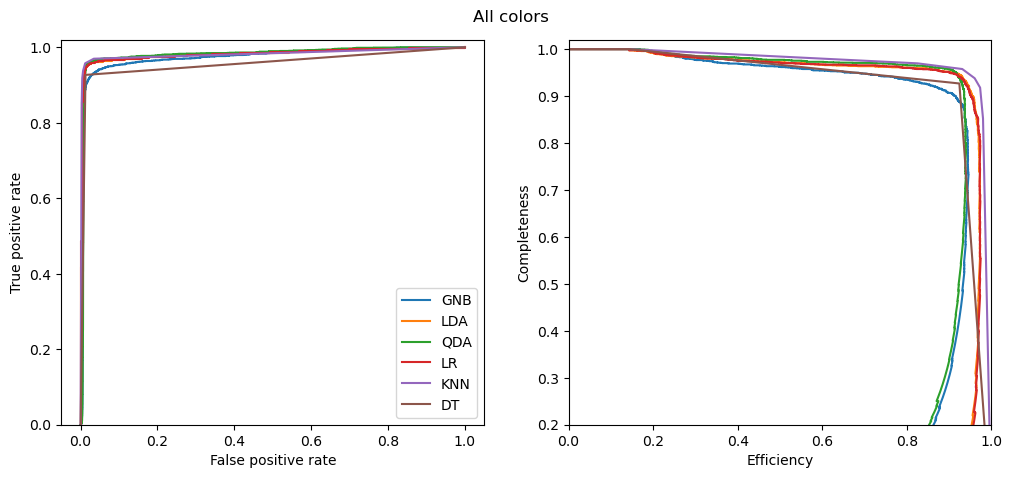

In [24]:
ROC(color)

Also in this case we obtain good results.

## Predictions

#### 2 colors

Plotting the predictions of all the classifiers using the couple u-g and g-r.

In [25]:
(X_train, X_test), (y_train, y_test) = split_samples(color.iloc[:, [0,1]], df_quasar['class'], [0.70, 0.30], random_state=42)
pred, accuracy, classifier = prediction(X_train, X_test, y_train, y_test)

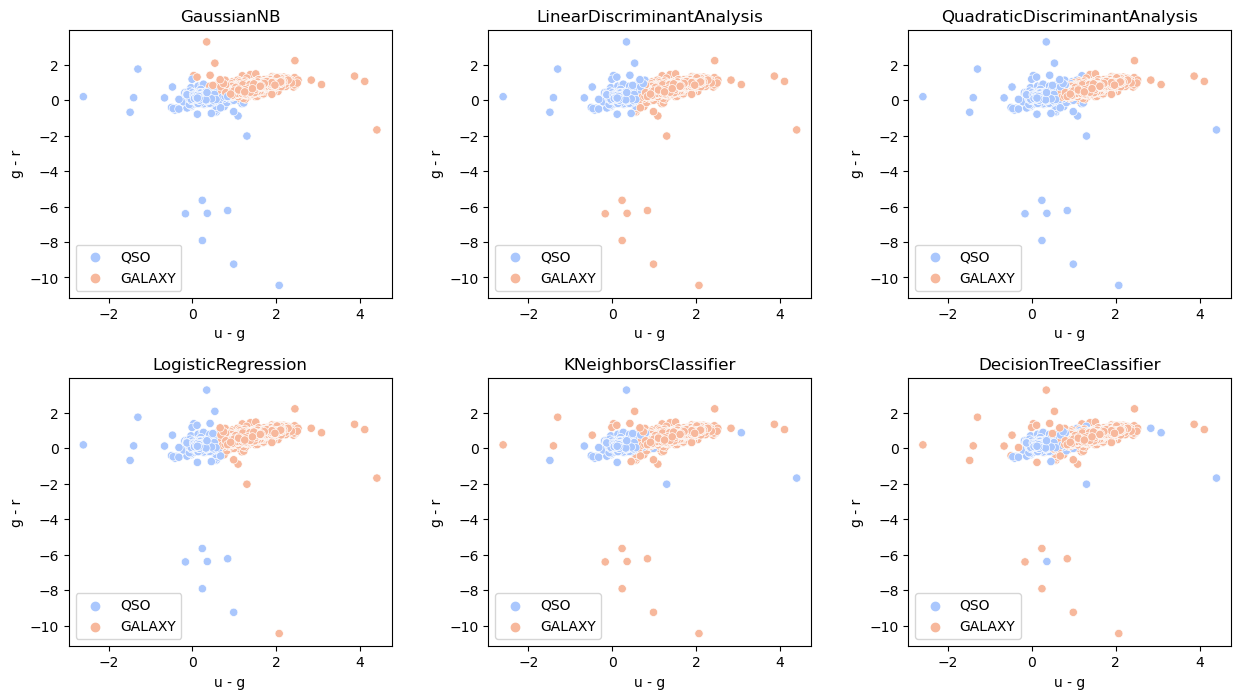

In [26]:
clrs = pd.DataFrame({'u - g': X_test[:, 0], 'g - r': X_test[:, 1]})

fig, axs = plt.subplots(2, 3, figsize=(15, 8))
sns.scatterplot(data=clrs, x='u - g', y='g - r', ax=axs[0,0], hue=le.inverse_transform(pred[0]), palette='coolwarm')
axs[0,0].set_title('GaussianNB')
sns.scatterplot(data=clrs, x='u - g', y='g - r', ax=axs[0,1], hue=le.inverse_transform(pred[1]), palette='coolwarm')
axs[0,1].set_title('LinearDiscriminantAnalysis')
sns.scatterplot(data=clrs, x='u - g', y='g - r', ax=axs[0,2], hue=le.inverse_transform(pred[2]), palette='coolwarm')
axs[0,2].set_title('QuadraticDiscriminantAnalysis')
sns.scatterplot(data=clrs, x='u - g', y='g - r', ax=axs[1,0], hue=le.inverse_transform(pred[3]), palette='coolwarm')
axs[1,0].set_title('LogisticRegression')
sns.scatterplot(data=clrs, x='u - g', y='g - r', ax=axs[1,1], hue=le.inverse_transform(pred[4]), palette='coolwarm')
axs[1,1].set_title('KNeighborsClassifier')
sns.scatterplot(data=clrs, x='u - g', y='g - r', ax=axs[1,2], hue=le.inverse_transform(pred[5]), palette='coolwarm')
axs[1,2].set_title('DecisionTreeClassifier')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [27]:
#Printing the confusion matrixes
print('Confusion matrix:\n')
for i in range(len(classifier)):
    print('%s:' %classifier[i])
    print('Accuracy: %0.4f' %accuracy[i])
    print('Confusion matrix:')
    print(confusion_matrix(y_test, pred[i]),'\n')

Confusion matrix:

GaussianNB():
Accuracy: 0.9719
Confusion matrix:
[[12590   265]
 [  157  1988]] 

LinearDiscriminantAnalysis():
Accuracy: 0.9817
Confusion matrix:
[[12730   125]
 [  149  1996]] 

QuadraticDiscriminantAnalysis():
Accuracy: 0.9809
Confusion matrix:
[[12705   150]
 [  137  2008]] 

LogisticRegression():
Accuracy: 0.9801
Confusion matrix:
[[12736   119]
 [  179  1966]] 

KNeighborsClassifier():
Accuracy: 0.9814
Confusion matrix:
[[12733   122]
 [  157  1988]] 

DecisionTreeClassifier():
Accuracy: 0.9723
Confusion matrix:
[[12662   193]
 [  223  1922]] 



#### 1 color

Plotting the predictions of all colors individually, using a Logistic Regressor since, looking at the ROC curves, gives pretty good results.

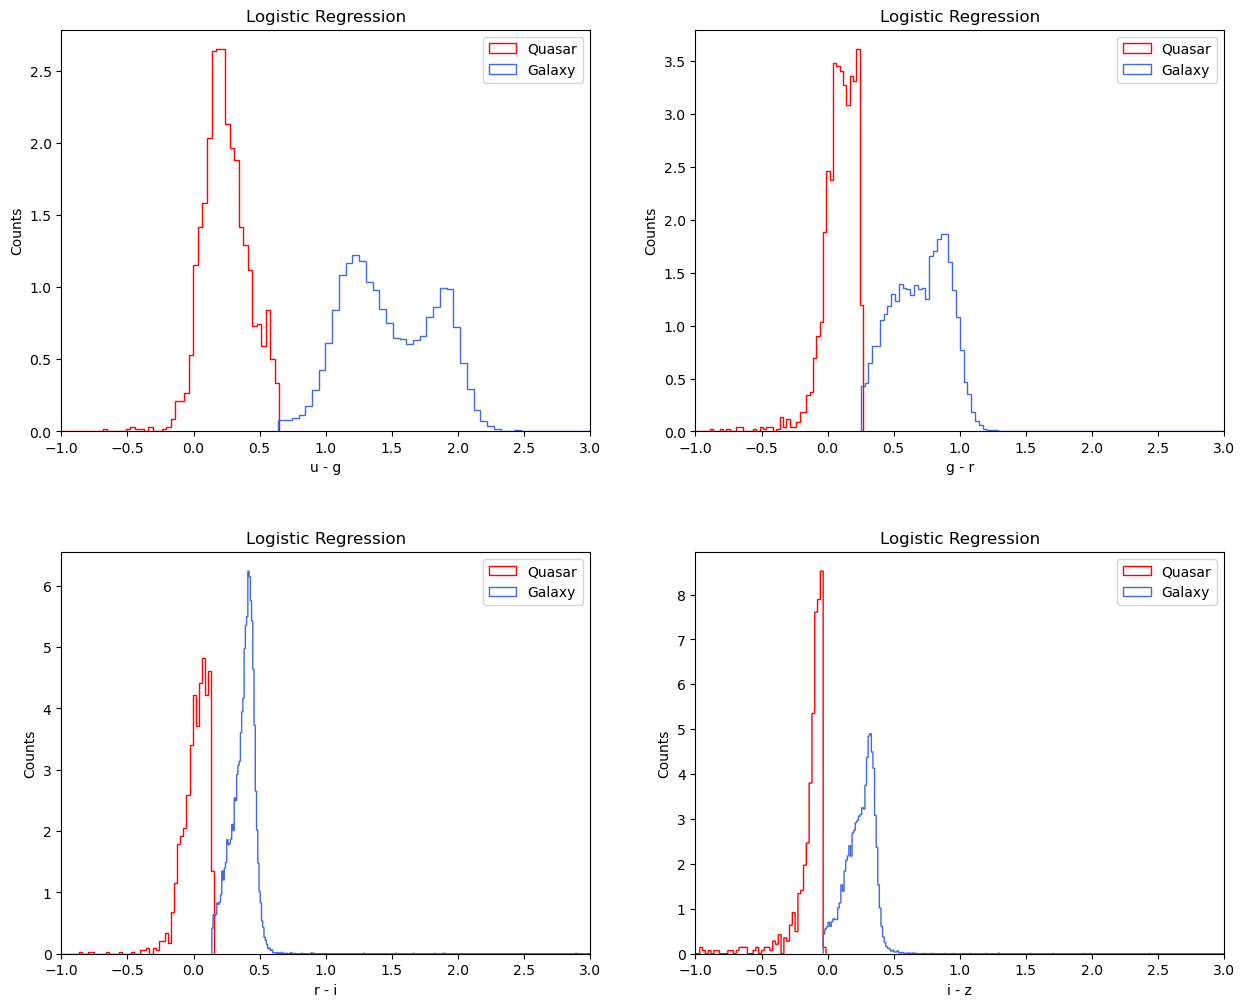

In [32]:
acc = []

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

(X_train, X_test), (y_train, y_test) = split_samples(color.iloc[:, [0]], df_quasar['class'], [0.70, 0.30], random_state=42)
pred, accuracy, classifier = prediction(X_train, X_test, y_train, y_test)
c_1 = confusion_matrix(y_test, pred[3])
acc.append(accuracy[3])
fancyhist(X_test[pred[3]==1, 0], bins="freedman", ax=axs[0,0], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(X_test[pred[3]==0, 0], bins="freedman", ax=axs[0,0], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[0,0].set_xlabel('u - g')
axs[0,0].set_ylabel('Counts')
axs[0,0].set_title('Logistic Regression')
axs[0,0].set_xlim(-1, 3)
axs[0,0].legend()

(X_train, X_test), (y_train, y_test) = split_samples(color.iloc[:, [1]], df_quasar['class'], [0.70, 0.30], random_state=42)
pred, accuracy, classifier = prediction(X_train, X_test, y_train, y_test)
c_2 = confusion_matrix(y_test, pred[3])
acc.append(accuracy[3])
fancyhist(X_test[pred[3]==1, 0], bins="freedman", ax=axs[0,1], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(X_test[pred[3]==0, 0], bins="freedman", ax=axs[0,1], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[0,1].set_xlabel('g - r')
axs[0,1].set_ylabel('Counts')
axs[0,1].set_title('Logistic Regression')
axs[0,1].set_xlim(-1, 3)
axs[0,1].legend()

(X_train, X_test), (y_train, y_test) = split_samples(color.iloc[:, [2]], df_quasar['class'], [0.70, 0.30], random_state=42)
pred, accuracy, classifier = prediction(X_train, X_test, y_train, y_test)
c_3 = confusion_matrix(y_test, pred[3])
acc.append(accuracy[3])
fancyhist(X_test[pred[3]==1, 0], bins="freedman", ax=axs[1,0], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(X_test[pred[3]==0, 0], bins="freedman", ax=axs[1,0], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[1,0].set_xlabel('r - i')
axs[1,0].set_ylabel('Counts')
axs[1,0].set_title('Logistic Regression')
axs[1,0].set_xlim(-1, 3)
axs[1,0].legend()

(X_train, X_test), (y_train, y_test) = split_samples(color.iloc[:, [3]], df_quasar['class'], [0.70, 0.30], random_state=42)
pred, accuracy, classifier = prediction(X_train, X_test, y_train, y_test)
c_4 = confusion_matrix(y_test, pred[3])
acc.append(accuracy[3])
fancyhist(X_test[pred[3]==1, 0], bins="freedman", ax=axs[1,1], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(X_test[pred[3]==0, 0], bins="freedman", ax=axs[1,1], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[1,1].set_xlabel('i - z')
axs[1,1].set_ylabel('Counts')
axs[1,1].set_title('Logistic Regression')
axs[1,1].set_xlim(-1, 3)
axs[1,1].legend()

plt.subplots_adjust(hspace=0.3)
plt.show()

In [29]:
C = [c_1, c_2, c_3, c_4]
i=0
for lab, c in zip(color.columns.tolist(), C):
    print('%s:' %lab)
    print('Accuracy: %0.4f' %acc[i])
    print('Confusion matrix:')
    print(c,'\n')
    i+=1

u - g:
Accuracy: 0.9801
Confusion matrix:
[[12738   117]
 [  181  1964]] 

g - r:
Accuracy: 0.9401
Confusion matrix:
[[12617   238]
 [  660  1485]] 

r - i:
Accuracy: 0.9207
Confusion matrix:
[[12697   158]
 [ 1031  1114]] 

i - z:
Accuracy: 0.8813
Confusion matrix:
[[12703   152]
 [ 1628   517]] 



#### All colors

In [30]:
(X_train, X_test), (y_train, y_test) = split_samples(color, df_quasar['class'], [0.70, 0.30], random_state=42)
pred, accuracy, classifier = prediction(X_train, X_test, y_train, y_test)

In [31]:
for i in range(len(classifier)):
    print('%s:' %classifier[i])
    print('Accuracy: %0.4f' %accuracy[i])
    print('Confusion matrix:')
    print(confusion_matrix(y_test, pred[i]),'\n')

GaussianNB():
Accuracy: 0.9683
Confusion matrix:
[[12550   305]
 [  170  1975]] 

LinearDiscriminantAnalysis():
Accuracy: 0.9814
Confusion matrix:
[[12728   127]
 [  152  1993]] 

QuadraticDiscriminantAnalysis():
Accuracy: 0.9796
Confusion matrix:
[[12705   150]
 [  156  1989]] 

LogisticRegression():
Accuracy: 0.9805
Confusion matrix:
[[12737   118]
 [  175  1970]] 

KNeighborsClassifier():
Accuracy: 0.9856
Confusion matrix:
[[12772    83]
 [  133  2012]] 

DecisionTreeClassifier():
Accuracy: 0.9794
Confusion matrix:
[[12702   153]
 [  156  1989]] 

